This notebook takes the combined run- and experiment-wide metrics of each sequence-charge, and builds a run-specific estimator for intensity delta.

X is a sequence's attributes in a run:
- log2 intensity
- uncalibrated m/z (the raw intensity as extracted by TFD)
- charge
- retention time
- CCS

y is the delta of intensity in a run from the median intensity of the sequence over the experiment.

For training, filter:
- human only
- only sequences detected in at least half the runs
- only 1to1 runs

In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV,ShuffleSplit,RandomizedSearchCV

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [4]:
# produced by the notebook "classify all features extracted from all the runs"
SEQUENCES_WITH_SPECIES_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/sequences-with-species-df.pkl'
# copied from BAM
MAPPING_FILE_NAME = "/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/recalibrated-percolator-output/percolator-idx-mapping.csv"
TARGET_DECOY_MODEL_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/target-decoy-models'
EXPERIMENT_METRICS_FILE_NAME = "{}/experiment-metrics-for-library-sequences.pkl".format(TARGET_DECOY_MODEL_DIR)

In [5]:
# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

In [6]:
def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result


In [7]:
get_percolator_run_mapping(MAPPING_FILE_NAME)

[(0, '190719_Hela_Ecoli_1to3_06'),
 (1, '190719_Hela_Ecoli_1to1_07'),
 (2, '190719_Hela_Ecoli_1to1_09'),
 (3, '190719_Hela_Ecoli_1to3_09'),
 (4, '190719_Hela_Ecoli_1to3_05'),
 (5, '190719_Hela_Ecoli_1to3_01'),
 (6, '190719_Hela_Ecoli_1to1_03'),
 (7, '190719_Hela_Ecoli_1to3_08'),
 (8, '190719_Hela_Ecoli_1to1_10'),
 (9, '190719_Hela_Ecoli_1to3_07'),
 (10, '190719_Hela_Ecoli_1to1_08'),
 (11, '190719_Hela_Ecoli_1to1_01'),
 (12, '190719_Hela_Ecoli_1to3_04'),
 (13, '190719_Hela_Ecoli_1to3_03'),
 (14, '190719_Hela_Ecoli_1to3_10'),
 (15, '190719_Hela_Ecoli_1to1_04'),
 (16, '190719_Hela_Ecoli_1to1_02'),
 (17, '190719_Hela_Ecoli_1to3_02'),
 (18, '190719_Hela_Ecoli_1to1_05'),
 (19, '190719_Hela_Ecoli_1to1_06')]

In [8]:
sequences_with_species_df = pd.read_pickle(SEQUENCES_WITH_SPECIES_FILE_NAME)

In [9]:
sequences_with_species_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity', 'classed_as', 'run_name',
       'batch', 'human'],
      dtype='object')

In [10]:
sequences_with_species_df.isnull().sum()

sequence      0
charge        0
file_idx      0
intensity     0
classed_as    0
run_name      0
batch         0
human         0
dtype: int64

In [11]:
experiment_metrics_for_library_sequences_df = pd.read_pickle(EXPERIMENT_METRICS_FILE_NAME)

In [12]:
experiment_metrics_for_library_sequences_df.columns

Index(['sequence', 'charge', 'theoretical_mz', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'experiment_scan_peak_width',
       'experiment_rt_mean', 'experiment_rt_std_dev',
       'experiment_rt_peak_width', 'experiment_intensity_mean',
       'experiment_intensity_std_dev', 'number_of_runs_identified', 'q_value',
       'file_idx', 'target_coords', 'decoy_coords', 'target_metrics',
       'attributes', 'decoy_metrics'],
      dtype='object')

In [13]:
experiment_metrics_for_library_sequences_df.isnull().sum()

sequence                         0
charge                           0
theoretical_mz                   0
experiment_scan_mean             0
experiment_scan_std_dev          0
experiment_scan_peak_width       0
experiment_rt_mean               0
experiment_rt_std_dev            0
experiment_rt_peak_width         0
experiment_intensity_mean        0
experiment_intensity_std_dev     0
number_of_runs_identified        0
q_value                          0
file_idx                         0
target_coords                    0
decoy_coords                     0
target_metrics                   2
attributes                       0
decoy_metrics                   10
dtype: int64

#### Merge the unpacked attributes of the TFD-extracted sequence (in experiment_metrics_for_library_sequences_df) with the sequences_with_species_df

In [14]:
# unpack the TFD-extracted attributes from each sequence
attributes = []
attribute_names = [key for key in sorted(experiment_metrics_for_library_sequences_df.iloc[0].attributes)]

for row in experiment_metrics_for_library_sequences_df.itertuples():
    # target metric valuesa
    d = row.attributes
    if (d is not None):
        # check whether any of the values are None
        all_not_none = True
        for k,v in d.items(): 
            if d[k] is None:
                all_not_none = False
                break
        # add the attributes to the collection
        if all_not_none == True:
            l = []
            l.append(row.sequence)
            l.append(row.charge)
            l.append(row.file_idx)
            l += [d[key] for key in sorted(d)]
            attributes.append(tuple(l))

columns = ['sequence','charge','file_idx']
columns += attribute_names

attributes_as_extracted_df = pd.DataFrame(attributes, columns=columns)

In [15]:
attributes_as_extracted_df.isnull().sum()

sequence                              0
charge                                0
file_idx                              0
intensity_all_points                  0
intensity_saturation_adjusted         0
intensity_saturation_adjusted_flag    0
intensity_top_3                       0
isotope_idx_not_in_saturation         0
monoisotopic_mz                       0
rt_apex                               0
scan_apex                             0
dtype: int64

In [16]:
len(attributes_as_extracted_df)

364

In [17]:
attributes_as_extracted_df.intensity_top_3.max(), attributes_as_extracted_df.intensity_top_3.min()

(19361, 0)

In [18]:
attributes_as_extracted_df.head()

,sequence,charge,file_idx,intensity_all_points,intensity_saturation_adjusted,intensity_saturation_adjusted_flag,intensity_top_3,isotope_idx_not_in_saturation,monoisotopic_mz,rt_apex,scan_apex
0,THIQDNHDGTYTVAYVPDVTGR,3,0,9445,16317,0,573,0,820.390876,558.171730,681.945202
1,EKEDDEEEEDEDASGGDQDQEER,2,0,200,674,0,89,0,1341.999189,205.452328,121.413155
2,VEQVLSLEPQHELK,3,0,2058,44887,0,226,0,550.301444,581.761002,847.093627
3,DVTRGQAAVQQLQAEGLSPR,2,0,14622,78741,1,468,1,1062.561285,833.562564,90.288343
4,YFFM[15.9949]GISFM[15.9949]VIVWAGTFALMI,3,0,3157,6005,0,220,0,826.077021,1092.093000,631.747452


In [19]:
len(sequences_with_species_df)

316

In [20]:
len(attributes_as_extracted_df)

364

In [21]:
sequences_with_attributes_df = pd.merge(attributes_as_extracted_df, sequences_with_species_df, how='inner', left_on=['sequence','charge','file_idx'], right_on=['sequence','charge','file_idx'])
sequences_with_attributes_df['log_intensity'] = np.log2(sequences_with_attributes_df.intensity_saturation_adjusted)


In [22]:
sequences_with_attributes_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity_all_points',
       'intensity_saturation_adjusted', 'intensity_saturation_adjusted_flag',
       'intensity_top_3', 'isotope_idx_not_in_saturation', 'monoisotopic_mz',
       'rt_apex', 'scan_apex', 'intensity', 'classed_as', 'run_name', 'batch',
       'human', 'log_intensity'],
      dtype='object')

In [23]:
len(sequences_with_attributes_df)

315

In [24]:
# find the experiment-wide means and std devs
experiment_intensities_l = []
for group_name,group_df in sequences_with_attributes_df.groupby(['sequence','charge'], as_index=False):
    number_of_runs_for_sequence = len(group_df)
    # intensity
    experiment_intensity_mean = np.mean(group_df.log_intensity)
    experiment_intensity_std_dev = np.std(group_df.log_intensity)
    # rt
    experiment_rt_mean = np.mean(group_df.rt_apex)
    experiment_rt_std_dev = np.std(group_df.rt_apex)
    # scan
    experiment_scan_mean = np.mean(group_df.scan_apex)
    experiment_scan_std_dev = np.std(group_df.scan_apex)
    # sequence and charge
    sequence = group_name[0]
    charge = group_name[1]
    experiment_intensities_l.append((sequence,charge,experiment_intensity_mean,experiment_intensity_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,number_of_runs_for_sequence))

experiment_intensities_df = pd.DataFrame(experiment_intensities_l, columns=['sequence','charge','experiment_intensity_mean','experiment_intensity_std_dev','experiment_rt_mean','experiment_rt_std_dev','experiment_scan_mean','experiment_scan_std_dev','number_of_runs_for_sequence'])


In [25]:
experiment_intensities_df.sample(10)

,sequence,charge,experiment_intensity_mean,experiment_intensity_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,number_of_runs_for_sequence
9809,GIEQAVQSHAVAEEEARK,3,14.204252,0.508074,416.002363,9.667870,772.732133,13.990083,18
19509,NLVEQHIQDIVVHYTFNK,3,15.760076,0.579222,833.401024,4.420820,651.217672,3.250518,20
19132,NFSGPVPDLPEGITVAYTIPK,2,15.969213,0.638552,978.008770,7.049019,113.701674,7.005425,18
949,AGTHDSHGAPLGDAEIALTR,2,17.037708,0.869326,540.534281,4.497099,219.363696,4.216409,20
715,AFGPGLQGGSAGSPAR,2,20.828863,0.364267,446.276679,3.546780,635.485182,2.574978,20
6007,EHFQSYDLDHMEK,2,14.474380,0.269246,425.061277,3.868168,468.704939,5.285489,20
13261,IMVANIEEVLQR,2,17.464287,0.301027,863.138689,4.090311,561.720646,2.531461,20
12720,IGDYVQQHGGVSLVEQLLQDPK,3,15.900897,0.465579,933.729034,4.320251,648.225750,3.359559,20
1544,AMQRPETAATLK,2,16.205414,0.382078,283.689936,3.155620,642.093853,2.662321,20
21380,Q[-17.0265]CANLQNAIADAEQR,2,17.759262,0.387884,469.100548,5.290218,464.774769,9.505773,20


In [26]:
sequences_df = pd.merge(sequences_with_attributes_df, experiment_intensities_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])

In [27]:
sequences_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity_all_points',
       'intensity_saturation_adjusted', 'intensity_top_3', 'monoisotopic_mz',
       'rt_apex', 'scan_apex', 'intensity', 'classed_as', 'run_name', 'batch',
       'human', 'log_intensity', 'experiment_intensity_mean',
       'experiment_intensity_std_dev', 'experiment_rt_mean',
       'experiment_rt_std_dev', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'number_of_runs_for_sequence'],
      dtype='object')

#### Note that from now on we work with intensity and intensity delta in log2 space. The median is the median of log2(intensity).

In [28]:
sequences_df['delta_intensity'] = sequences_df.log_intensity - sequences_df.experiment_intensity_mean


In [29]:
file_idx = 2
run_name = run_name_for_file_idx(file_idx)
run_name

'190719_Hela_Ecoli_1to1_09'

In [30]:
minimum_number_of_runs_for_training_set = 10

In [ ]:
EXPERIMENT_DIR = '/home/ubuntu/experiments/dwm-test'
EXTRACTED_FEATURES_DIR = "{}/extracted-features".format(EXPERIMENT_DIR)
EXTRACTED_FEATURES_DB_NAME = "{}/extracted-features.sqlite".format(EXTRACTED_FEATURES_DIR)


In [ ]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
sequences_df = pd.read_sql_query('select sequence,charge,file_idx,peak_idx,number_of_runs_extracted,human,run_name,batch,intensity,isotope_idx_not_in_saturation from features where human is false and number_of_runs_extracted >= 15 order by intensity desc', db_conn)
db_conn.close()


In [31]:
# make the training set from human only, comprising sequences we have identified in a minimum of runs
training_set_all_runs_df = sequences_df[(sequences_df.human == True) & (sequences_df.number_of_runs_for_sequence > minimum_number_of_runs_for_training_set)].copy()
training_set_selected_run_df = training_set_all_runs_df[training_set_all_runs_df.file_idx == file_idx]


In [32]:
print("training set is {}% of the complete sequence set".format(round(len(training_set_all_runs_df) / len(sequences_df) * 100, 1)))

training set is 78.5% of the complete sequence set


In [33]:
print("{}% of the sequences in this run are in the training set".format(round(len(training_set_selected_run_df) / len(sequences_df[sequences_df.file_idx == file_idx]) * 100, 1)))

79.6% of the sequences in this run are in the training set


In [34]:
training_set_selected_run_df.sample(5)

,sequence,charge,file_idx,intensity_all_points,intensity_saturation_adjusted,intensity_top_3,monoisotopic_mz,rt_apex,scan_apex,intensity,...,human,log_intensity,experiment_intensity_mean,experiment_intensity_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,number_of_runs_for_sequence,delta_intensity
59044,EEGTPWNEDCGK,2,2,5141,20328,606,711.285226,351.910780,688.466707,606,...,True,14.311181,13.631678,0.524236,353.788075,6.351509,689.345744,7.837838,15,0.679503
75570,SYPLQDFSSLKLPHLK,2,2,6083,21876,421,937.014945,668.519323,260.294641,421,...,True,14.417061,15.890557,1.271633,666.828188,3.530160,244.538709,8.520758,19,-1.473495
63895,HDADGQATLLNLLLR,2,2,1367,22755,126,825.451644,1017.477279,399.324980,126,...,True,14.473896,14.900087,0.473853,1018.587056,2.283987,380.506567,6.968723,20,-0.426191
65962,IQASQQDDSMR,2,2,1832,337483,462,639.791216,231.663124,732.081491,462,...,True,18.364455,18.282512,0.441900,223.915846,4.371036,735.890656,8.844480,20,0.081943
63856,HAQANGFSVVR,2,2,21514,315997,1096,593.309986,323.442176,766.389655,1096,...,True,18.269551,18.411069,0.327305,326.619280,2.113082,770.795199,9.831480,20,-0.141517


In [35]:
len(training_set_selected_run_df)

21116

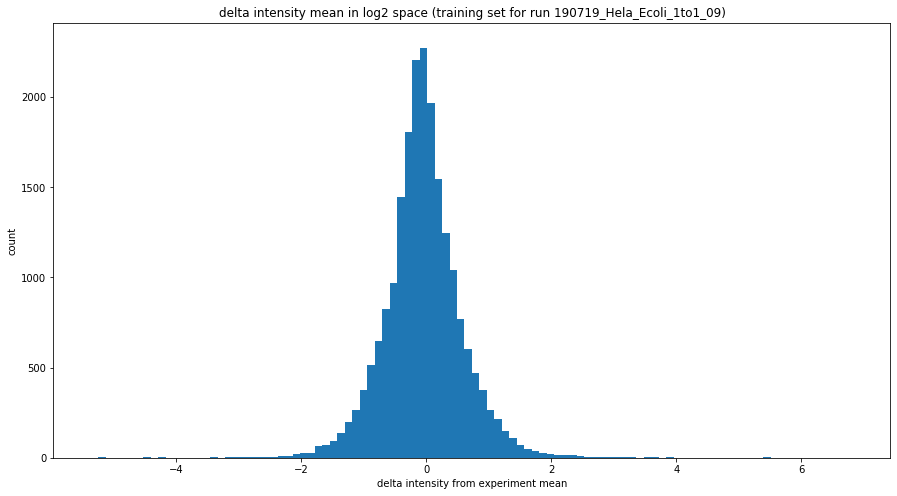

In [36]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(training_set_selected_run_df.delta_intensity, bins=bins)
plt.xlabel('delta intensity from experiment mean')
plt.ylabel('count')
plt.title('delta intensity mean in log2 space (training set for run {})'.format(run_name))

plt.show()

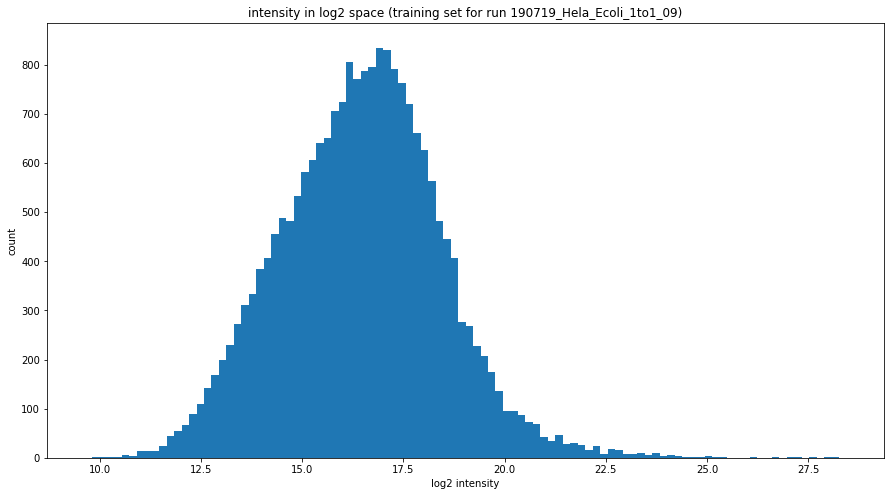

In [37]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(training_set_selected_run_df.log_intensity, bins=bins)
plt.xlabel('log2 intensity')
plt.ylabel('count')
plt.title('intensity in log2 space (training set for run {})'.format(run_name))

plt.show()

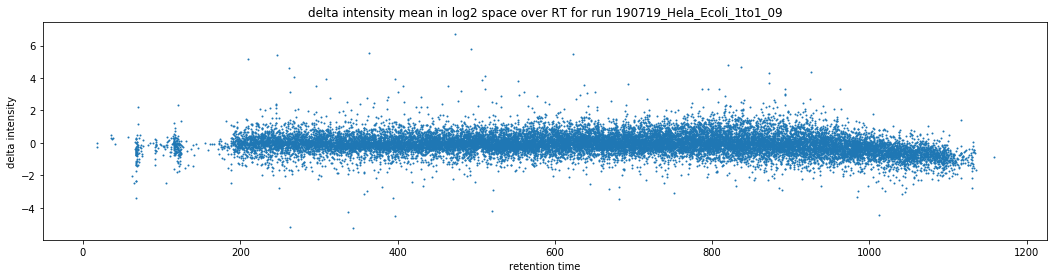

In [38]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(training_set_selected_run_df.rt_apex, training_set_selected_run_df.delta_intensity, marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta intensity')
plt.xlabel('retention time')
plt.title('delta intensity mean in log2 space over RT for run {}'.format(run_name))
# plt.xlim((300,400))
# plt.ylim((-2,2))

plt.show()

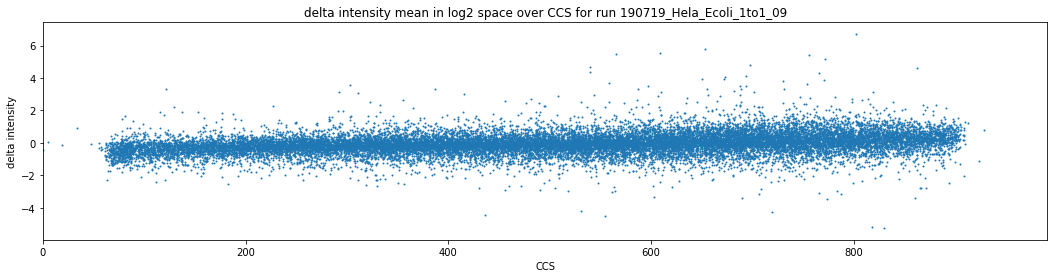

In [39]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(training_set_selected_run_df.scan_apex, training_set_selected_run_df.delta_intensity, marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta intensity')
plt.xlabel('CCS')
plt.title('delta intensity mean in log2 space over CCS for run {}'.format(run_name))
plt.xlim((0,991))
# plt.ylim((-2,2))

plt.show()

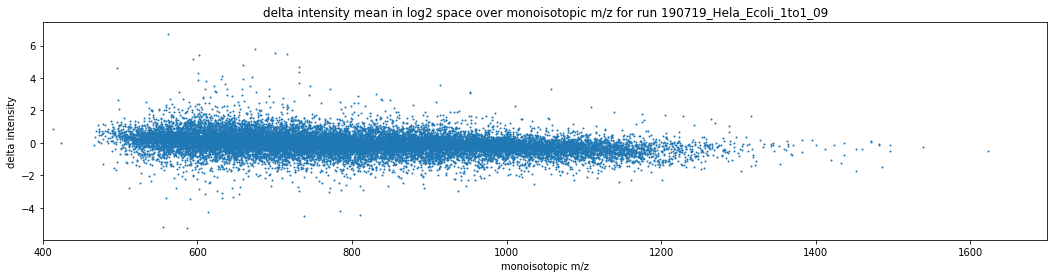

In [40]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)

ax.scatter(training_set_selected_run_df.monoisotopic_mz, training_set_selected_run_df.delta_intensity, marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta intensity')
plt.xlabel('monoisotopic m/z')
plt.title('delta intensity mean in log2 space over monoisotopic m/z for run {}'.format(run_name))
plt.xlim((400,1700))
# plt.ylim((-3,3))

plt.show()

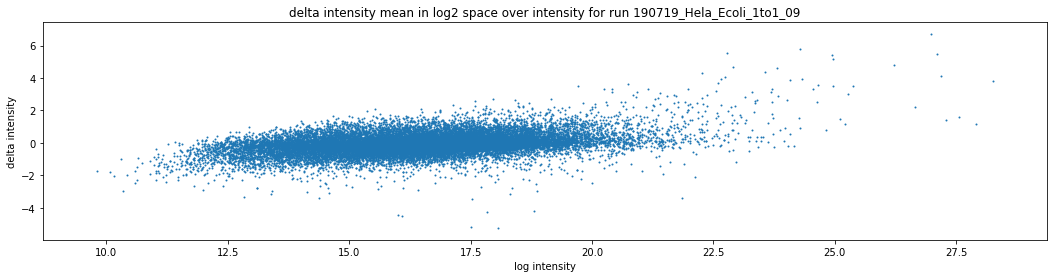

In [41]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)

ax.scatter(training_set_selected_run_df.log_intensity, training_set_selected_run_df.delta_intensity, marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta intensity')
plt.xlabel('log intensity')
plt.title('delta intensity mean in log2 space over intensity for run {}'.format(run_name))
# plt.xlim((400,1700))

plt.show()

#### create a gradient boosted regressor model

In [42]:
def GradientBooster(param_grid, n_jobs, X_train, y_train):
    estimator = GradientBoostingRegressor()
    cv = ShuffleSplit(n_splits=10, train_size=0.8, test_size=0.2, random_state=0)
    classifier = RandomizedSearchCV(estimator=estimator, cv=cv, param_distributions=param_grid, n_jobs=n_jobs)
    classifier.fit(X_train, y_train)
    print('best estimator found: {}'.format(classifier.best_estimator_))
    return cv, classifier.best_estimator_


#### train a model for a selected run

In [43]:
training_set_selected_run_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity_all_points',
       'intensity_saturation_adjusted', 'intensity_top_3', 'monoisotopic_mz',
       'rt_apex', 'scan_apex', 'intensity', 'classed_as', 'run_name', 'batch',
       'human', 'log_intensity', 'experiment_intensity_mean',
       'experiment_intensity_std_dev', 'experiment_rt_mean',
       'experiment_rt_std_dev', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'number_of_runs_for_sequence',
       'delta_intensity'],
      dtype='object')

In [44]:
training_attributes = ['log_intensity','experiment_intensity_mean','experiment_intensity_std_dev','experiment_rt_mean','experiment_rt_std_dev','experiment_scan_mean','experiment_scan_std_dev','charge']


In [45]:
training_set_selected_run_df[training_attributes].sample(10)

,log_intensity,experiment_intensity_mean,experiment_intensity_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,charge
80594,14.060949,14.748641,0.389287,612.332036,2.666733,590.646351,4.154214,3
67872,13.559258,13.120941,0.629471,808.635928,8.170855,678.521076,5.817434,3
57759,16.545658,15.972154,0.342830,487.870081,3.630370,849.808396,2.781640,2
78752,16.528469,17.529803,0.607783,260.833934,3.282003,559.127788,4.282233,2
69291,15.226788,15.336640,0.665951,724.573396,3.894083,782.578962,8.175515,3
66670,17.005942,17.128624,0.404366,113.985494,8.738056,894.001904,6.343009,2
72070,16.580980,16.654711,0.655954,536.997868,1.943077,536.470764,4.126844,2
74208,15.652173,15.582949,0.269142,215.217344,1.877140,620.718899,5.393623,2
74938,15.016808,13.986953,0.729170,655.780158,4.497053,677.741531,3.187645,2
59928,17.635746,17.077124,0.590815,690.854458,3.800884,596.251221,3.374368,3


In [46]:
# split the training set
X = training_set_selected_run_df[training_attributes].values
y = training_set_selected_run_df[['delta_intensity']].values[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [47]:
len(X_train), len(X_test)

(19004, 2112)

In [48]:
# create the model we will use
params = {'n_estimators': 1000, 'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 5, 'max_features': 1.0, 'loss':'huber'}
best_estimator = GradientBoostingRegressor(**params)


In [49]:
# train the model
best_estimator.fit(X_train, y_train)
train_score = best_estimator.score(X_train, y_train)
test_score = best_estimator.score(X_test, y_test)
print("R-squared for training set: {}, test set: {}".format(round(train_score,1), round(test_score, 1)))

R-squared for training set: 1.0, test set: 1.0


#### Plot the intensity error

In [50]:
feature_names = np.array(training_attributes)

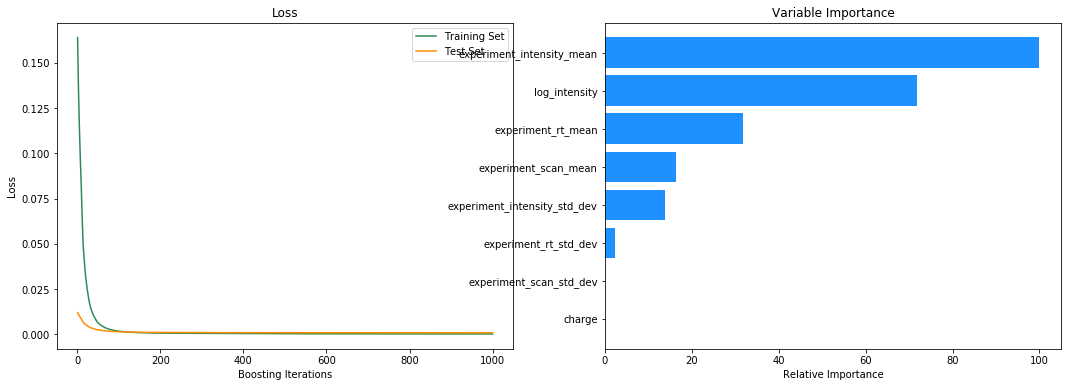

In [51]:
# Plot training loss

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(best_estimator.staged_predict(X_test)):
    test_score[i] = best_estimator.loss_(y_test, y_pred)

plt.figure(figsize=(18, 6))
plt.margins(0.06)
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(params['n_estimators']) + 1, best_estimator.train_score_, 'seagreen', label='Training Set')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'darkorange', label='Test Set')
plt.legend(loc='best')
plt.xlabel('Boosting Iterations')
plt.ylabel('Loss')

# Plot feature importance
feature_importance = best_estimator.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center', color='dodgerblue')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

plt.show()

In [52]:
# use the trained model to predict the intensity delta for the test set
y_test_predicted = best_estimator.predict(X_test)

#### train a model for each of the runs

In [53]:
mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)

In [54]:
for mapping in mapping_l:
    file_idx_for_this_model = mapping[0]
    
    # filter out rows we don't want in the training set for this run-specific model
    training_set_for_run_df = training_set_all_runs_df[(training_set_all_runs_df.file_idx == file_idx_for_this_model)]
    print("there are {} sequences in the training set for file {}".format(len(training_set_for_run_df), file_idx_for_this_model))

    # split the training set
    X = training_set_for_run_df[training_attributes].values
    y = training_set_for_run_df[['delta_intensity']].values[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    # train the model
    best_estimator.fit(X_train, y_train)
    train_score = best_estimator.score(X_train, y_train)
    test_score = best_estimator.score(X_test, y_test)
    print("R-squared for training set: {}, test set: {}".format(round(train_score,1), round(test_score, 1)))

    # save the trained model
    MODEL_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/intensity-models/file-{}-intensity-model.pkl'.format(file_idx_for_this_model)
    with open(MODEL_FILE_NAME, 'wb') as file:
        pickle.dump(best_estimator, file)

there are 21187 sequences in the training set for file 0
R-squared for training set: 1.0, test set: 1.0
there are 21364 sequences in the training set for file 1
R-squared for training set: 1.0, test set: 1.0
there are 21116 sequences in the training set for file 2
R-squared for training set: 1.0, test set: 1.0
there are 21121 sequences in the training set for file 3
R-squared for training set: 1.0, test set: 1.0
there are 21167 sequences in the training set for file 4
R-squared for training set: 1.0, test set: 1.0
there are 21467 sequences in the training set for file 5
R-squared for training set: 1.0, test set: 1.0
there are 21849 sequences in the training set for file 6
R-squared for training set: 1.0, test set: 1.0
there are 21142 sequences in the training set for file 7
R-squared for training set: 1.0, test set: 1.0
there are 20820 sequences in the training set for file 8
R-squared for training set: 1.0, test set: 1.0
there are 21230 sequences in the training set for file 9
R-squar

#### use the run-specific models to estimate the intensity for all sequences in all runs

In [55]:
sequences_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity_all_points',
       'intensity_saturation_adjusted', 'intensity_top_3', 'monoisotopic_mz',
       'rt_apex', 'scan_apex', 'intensity', 'classed_as', 'run_name', 'batch',
       'human', 'log_intensity', 'experiment_intensity_mean',
       'experiment_intensity_std_dev', 'experiment_rt_mean',
       'experiment_rt_std_dev', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'number_of_runs_for_sequence',
       'delta_intensity'],
      dtype='object')

In [116]:
sequences_df.human.unique()

array([ True, False])

In [115]:
# is a sequence-charge ever inferred to more than one species protein?
for group_name,group_df in sequences_df.groupby(['sequence','charge']):
    if len(group_df.human.unique()) > 1:
        print('yes')

In [84]:
sequences_l = []
for mapping in mapping_l:
    file_idx = mapping[0]
    
    # load the model for this run
    MODEL_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/intensity-models/file-{}-intensity-model.pkl'.format(file_idx)
    with open(MODEL_FILE_NAME, 'rb') as file:
        estimator = pickle.load(file)
    
    # get the sequences in this run
    df = sequences_df[sequences_df.file_idx == file_idx].copy()
    
    # build the list of sequences for inference
    X = df[training_attributes].values

    # predict the log2 delta intensity
    y = estimator.predict(X)
    
    df['estimated_delta_intensity'] = y
    df['normalised_log_intensity'] = df.log_intensity - y
    df['normalised_intensity'] = np.power(2, df.normalised_log_intensity)
    
    sequences_l.append(df)

sequences_df = pd.concat(sequences_l, axis=0, sort=False)

In [118]:
sequences_human_1to1_df = sequences_df[(sequences_df.human == True) & (sequences_df.batch == '1to1')]
sequences_human_1to3_df = sequences_df[(sequences_df.human == True) & (sequences_df.batch == '1to3')]
sequences_ecoli_1to1_df = sequences_df[(sequences_df.human == False) & (sequences_df.batch == '1to1')]
sequences_ecoli_1to3_df = sequences_df[(sequences_df.human == False) & (sequences_df.batch == '1to3')]


#### plot the estimated delta distributions

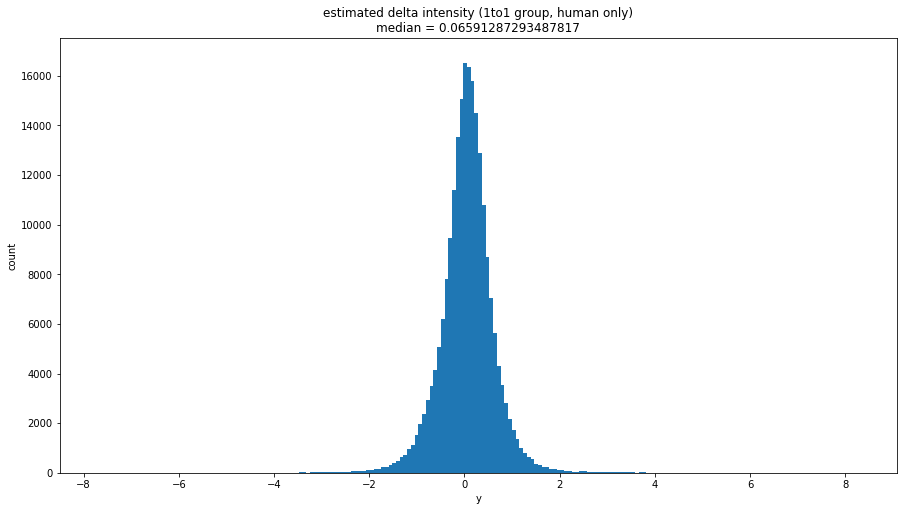

In [125]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('estimated delta intensity (1to1 group, human only)\nmedian = {}'.format(np.median(sequences_human_1to1_df.estimated_delta_intensity)))

bins = 200
hist, bins, _ = plt.hist(sequences_human_1to1_df.estimated_delta_intensity, bins=bins)
plt.xlabel('y')
plt.ylabel('count')

plt.show()

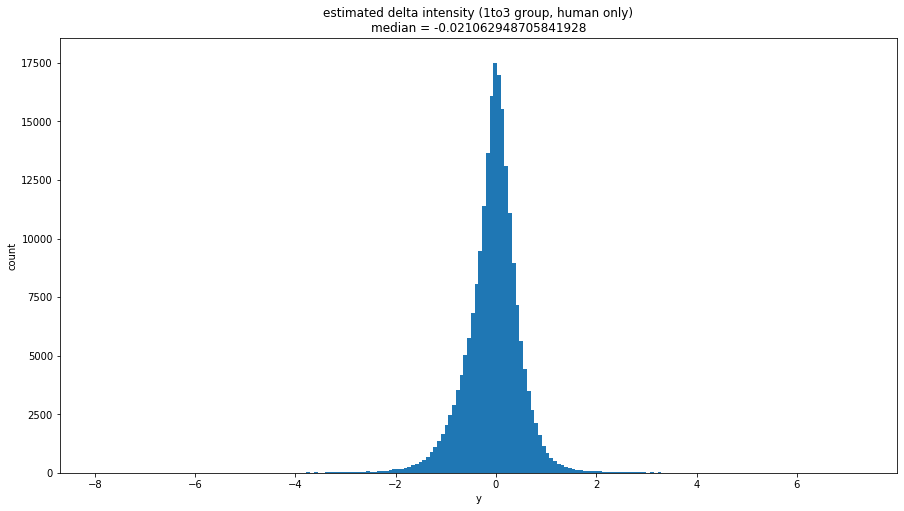

In [126]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('estimated delta intensity (1to3 group, human only)\nmedian = {}'.format(np.median(sequences_human_1to3_df.estimated_delta_intensity)))

bins = 200
hist, bins, _ = plt.hist(sequences_human_1to3_df.estimated_delta_intensity, bins=bins)
plt.xlabel('y')
plt.ylabel('count')

plt.show()

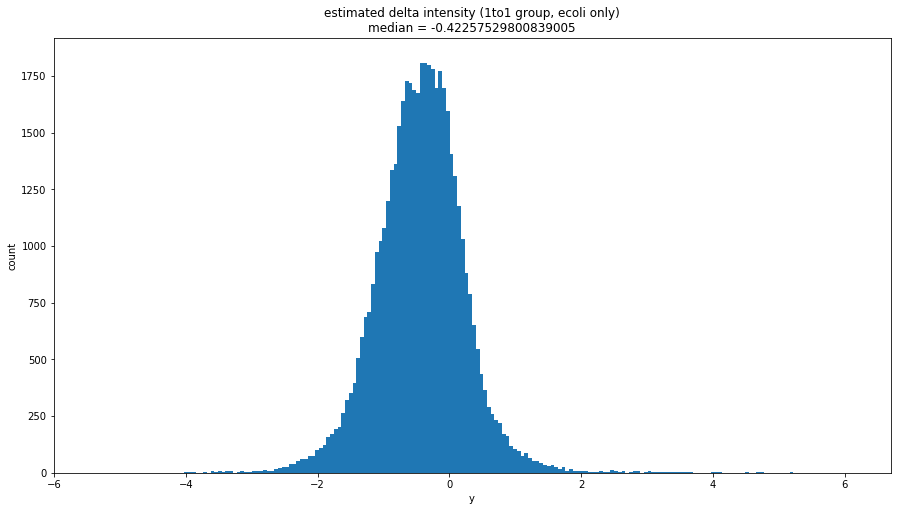

In [128]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('estimated delta intensity (1to1 group, ecoli only)\nmedian = {}'.format(np.median(sequences_ecoli_1to1_df.estimated_delta_intensity)))

bins = 200
hist, bins, _ = plt.hist(sequences_ecoli_1to1_df.estimated_delta_intensity, bins=bins)
plt.xlabel('y')
plt.ylabel('count')

plt.show()

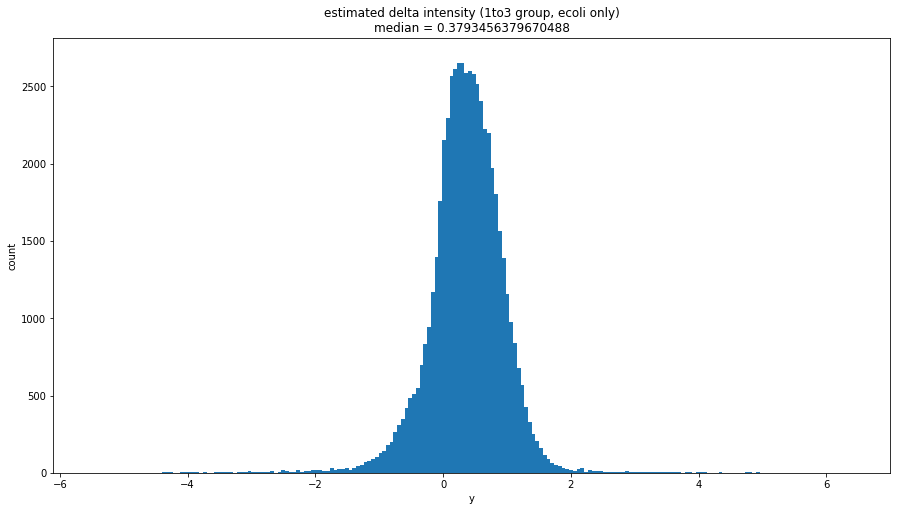

In [129]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('estimated delta intensity (1to3 group, ecoli only)\nmedian = {}'.format(np.median(sequences_ecoli_1to3_df.estimated_delta_intensity)))

bins = 200
hist, bins, _ = plt.hist(sequences_ecoli_1to3_df.estimated_delta_intensity, bins=bins)
plt.xlabel('y')
plt.ylabel('count')

plt.show()

#### plot the intensity of sequences seen in both 1to1 and 1to3 groups

In [156]:
ecoli_sequences_df = pd.merge(sequences_ecoli_1to1_df, sequences_ecoli_1to3_df, how='inner', left_on=['sequence','charge'], right_on=['sequence','charge'])
ecoli_sequences_df['intensity_ratio_all_points'] = ecoli_sequences_df.intensity_all_points_y / ecoli_sequences_df.intensity_all_points_x
ecoli_sequences_df['intensity_ratio_saturation_adjusted'] = ecoli_sequences_df.intensity_saturation_adjusted_y / ecoli_sequences_df.intensity_saturation_adjusted_x
ecoli_sequences_df['intensity_ratio_top_3'] = ecoli_sequences_df.intensity_top_3_y / ecoli_sequences_df.intensity_top_3_x


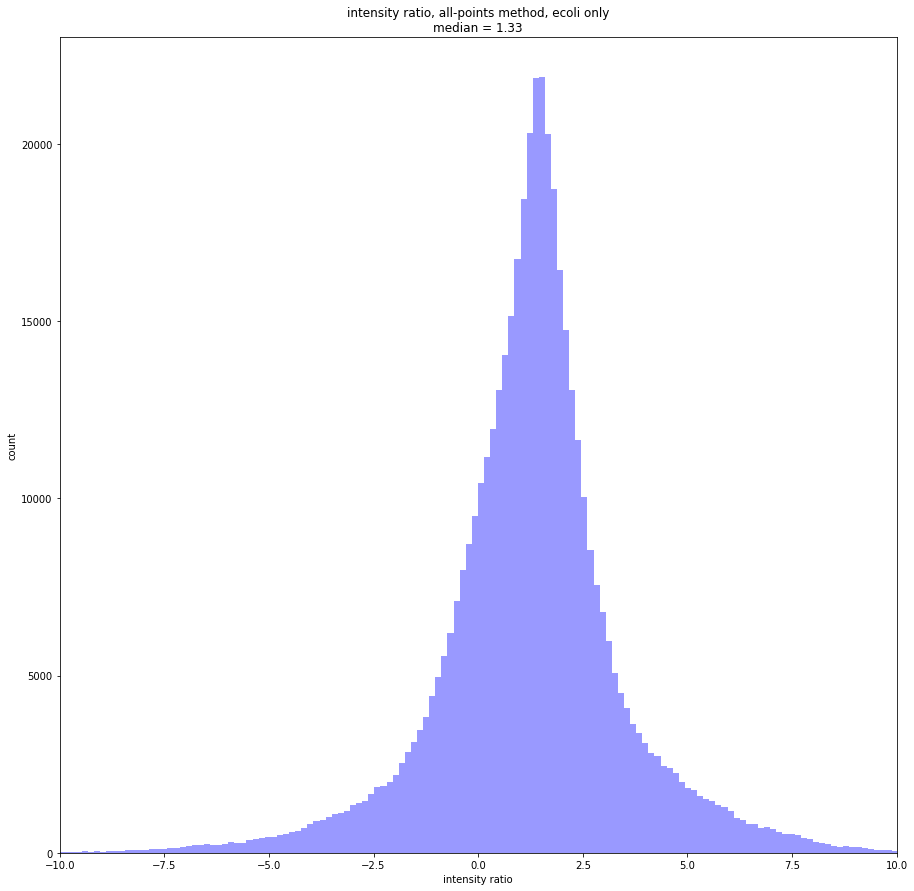

In [183]:
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('intensity ratio, all-points method, ecoli only\nmedian = {}'.format(round(np.median(np.log2(ecoli_sequences_df.intensity_ratio_all_points)),2)))

bins = 200

plt.hist(np.log2(ecoli_sequences_df.intensity_ratio_all_points), bins=bins, alpha=0.4, color='blue')

plt.xlabel('intensity ratio')
plt.ylabel('count')

plt.xlim((-10,10))
plt.ylim((0,23000))

plt.show()

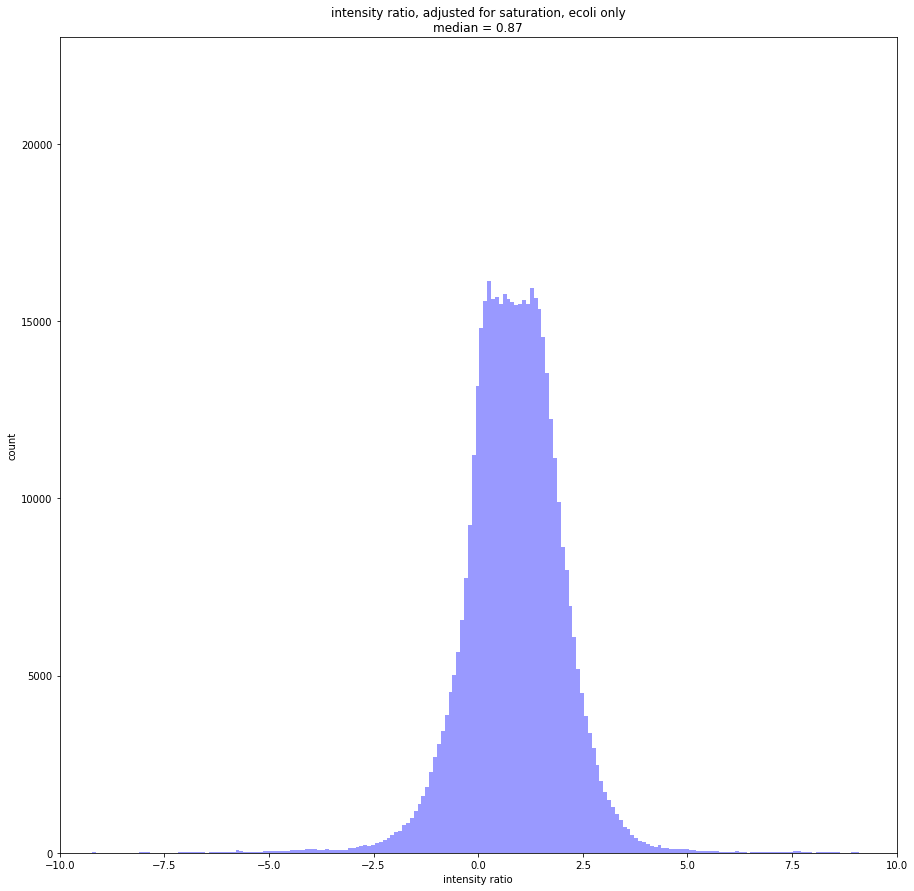

In [184]:
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('intensity ratio, adjusted for saturation, ecoli only\nmedian = {}'.format(round(np.median(np.log2(ecoli_sequences_df.intensity_ratio_saturation_adjusted)),2)))

bins = 200

plt.hist(np.log2(ecoli_sequences_df.intensity_ratio_saturation_adjusted), bins=bins, alpha=0.4, color='blue')

plt.xlabel('intensity ratio')
plt.ylabel('count')

plt.xlim((-10,10))
plt.ylim((0,23000))

plt.show()

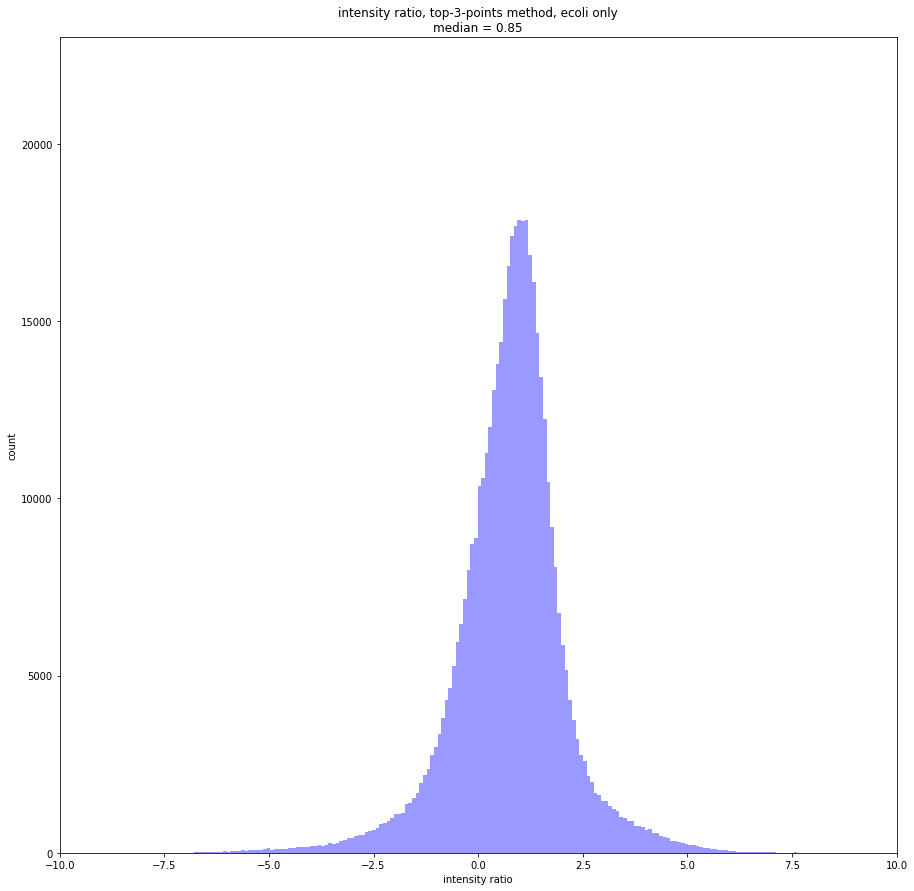

In [185]:
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('intensity ratio, top-3-points method, ecoli only\nmedian = {}'.format(round(np.median(np.log2(ecoli_sequences_df.intensity_ratio_top_3)),2)))

bins = 200

plt.hist(np.log2(ecoli_sequences_df.intensity_ratio_top_3), bins=bins, alpha=0.4, color='blue')

plt.xlabel('intensity ratio')
plt.ylabel('count')

plt.xlim((-10,10))
plt.ylim((0,23000))

plt.show()

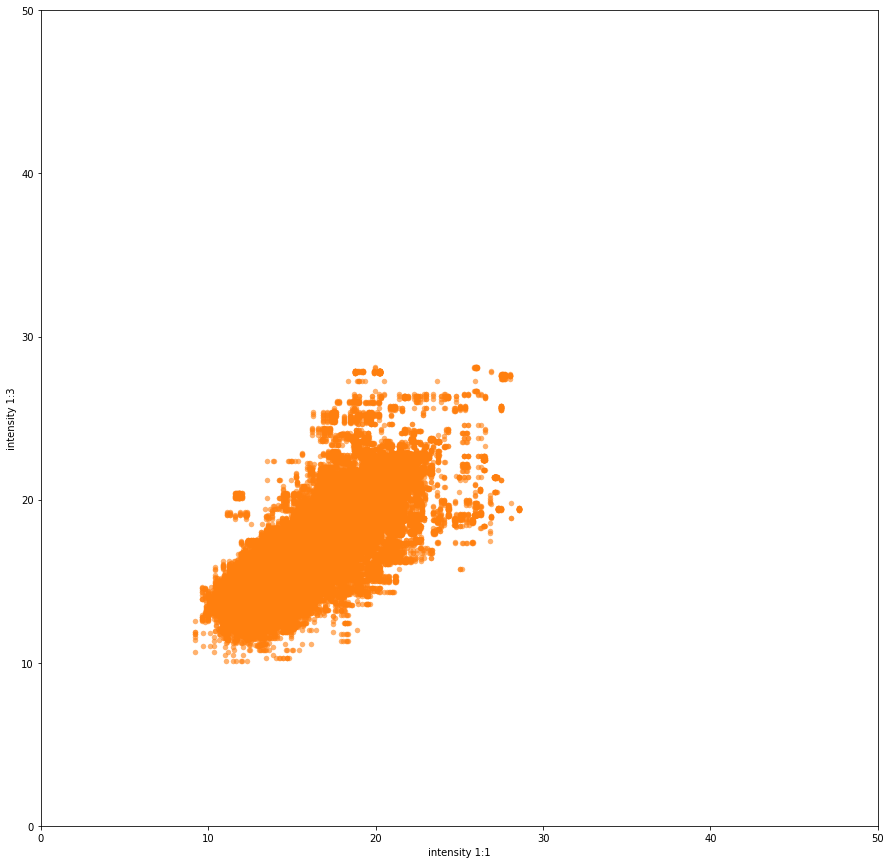

In [189]:
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)
# plt.title('estimated delta intensity (1to3 group, ecoli only)\nmedian = {}'.format(np.median(sequences_ecoli_1to3_df.estimated_delta_intensity)))

# plt.hist(ecoli_sequences_df.intensity_ratio_all_points, bins=bins, alpha=0.4, color='blue')
# plt.hist(ecoli_sequences_df.intensity_ratio_saturation_adjusted, bins=bins, alpha=0.4, color='red')
# plt.hist(ecoli_sequences_df.intensity_ratio_top_3, bins=bins, alpha=0.4, color='green')

# ax1.scatter(np.log2(ecoli_sequences_df.intensity_all_points_x), np.log2(ecoli_sequences_df.intensity_all_points_y), marker='o', color='tab:green', lw=0, s=30, alpha=0.6, label='all points')
ax1.scatter(np.log2(ecoli_sequences_df.intensity_saturation_adjusted_x), np.log2(ecoli_sequences_df.intensity_saturation_adjusted_y), marker='o', color='tab:orange', lw=0, s=30, alpha=0.6, label='all points')
# ax1.scatter(np.log2(ecoli_sequences_df.intensity_top_3_x), np.log2(ecoli_sequences_df.intensity_top_3_y), marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label='all points')

plt.xlabel('intensity 1:1')
plt.ylabel('intensity 1:3')

plt.xlim((0,50))
plt.ylim((0,50))

plt.show()

In [158]:
ecoli_sequences_df.sample(20)

,sequence,charge,file_idx_x,intensity_all_points_x,intensity_saturation_adjusted_x,intensity_top_3_x,monoisotopic_mz_x,rt_apex_x,scan_apex_x,intensity_x,...,experiment_scan_mean_y,experiment_scan_std_dev_y,number_of_runs_for_sequence_y,delta_intensity_y,estimated_delta_intensity_y,normalised_log_intensity_y,normalised_intensity_y,intensity_ratio_all_points,intensity_ratio_saturation_adjusted,intensity_ratio_top_3
125945,FGMHADVESADGDVHR,3,19,6043,19538,1016,581.590546,379.934295,816.216608,1016,...,819.622022,2.489763,20,0.893433,0.840321,14.851886,2.957080e+04,4.353301,2.709847,2.312992
388999,VALTGLTMAEK,2,2,15084,57067,856,567.315818,622.647839,768.189599,856,...,774.922266,12.885464,18,-0.669758,-0.651276,15.436984,4.436036e+04,0.043026,0.494945,0.143692
26850,ALGGGFPVGALLATEECAR,2,1,263529,590585,4850,944.983391,961.292006,288.133170,4850,...,282.978908,6.101672,20,1.043900,0.740786,20.624656,1.616739e+06,2.440927,4.574634,2.727010
374080,TMAVVAPLVLHLPAEEIASK,3,18,63897,134702,1925,697.060948,981.809851,809.440130,1925,...,805.302073,5.113576,20,0.847973,0.875481,17.654137,2.062646e+05,2.770083,2.809290,2.104416
324923,Q[-17.0265]QGTTADMIHK,2,1,8149,133264,671,606.789026,345.177224,782.034196,671,...,776.122310,25.121939,20,-0.223487,-0.191647,17.389747,1.717258e+05,1.966499,1.128317,1.740686
432732,YGAHGTSHFYVTQEAAK,3,16,43429,75028,3150,622.963340,319.407347,650.368147,3150,...,646.190498,2.931728,20,0.882445,0.979887,16.934019,1.252125e+05,3.372931,3.291544,1.888889
433310,YGFGSADAMQIMAEAEK,2,11,19090,25688,813,909.905287,840.667867,254.627608,813,...,249.123151,3.444772,20,0.923423,0.758397,16.243857,7.760474e+04,4.328339,5.110441,3.448954
121096,FDGVLASELADPQLYK,2,18,18413,322757,837,883.454504,855.263553,374.000000,837,...,348.291284,10.601759,20,0.206908,0.190138,18.633297,4.066131e+05,2.116765,1.437286,2.191159
311356,QTAFSQYDRPQAR,2,8,10746,25420,609,784.383872,329.418117,521.603985,609,...,517.975082,2.995762,19,0.790396,0.760411,15.722853,5.408171e+04,4.187977,3.603973,2.889984
435719,YLFAENPVVHLDTATSGSK,3,11,141,21584,141,683.681053,737.171087,815.465405,141,...,822.142154,18.776921,19,-0.861073,-0.778073,14.168645,1.841565e+04,8.929078,0.497544,2.198582


#### plot the intensity distributions

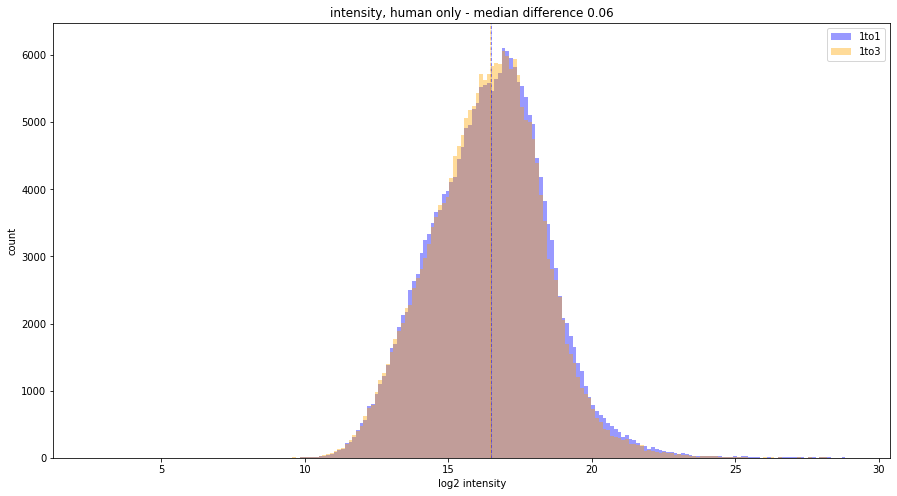

In [153]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('intensity, human only - median difference {}'.format(round(abs(np.median(sequences_human_1to1_df.log_intensity) - np.median(sequences_human_1to3_df.log_intensity)),2)))

bins = 200
hist, bins, _ = plt.hist(sequences_human_1to1_df.log_intensity, bins=bins, label='1to1', alpha=0.4, color='blue')
hist, bins, _ = plt.hist(sequences_human_1to3_df.log_intensity, bins=bins, label='1to3', alpha=0.4, color='orange')

plt.axvline(np.median(sequences_human_1to1_df.log_intensity), color='blue', lw=0.5, ls='-.')
plt.axvline(np.median(sequences_human_1to3_df.log_intensity), color='orange', lw=0.5, ls='-.')

plt.legend(loc='best')
plt.xlabel('log2 intensity')
plt.ylabel('count')

plt.show()

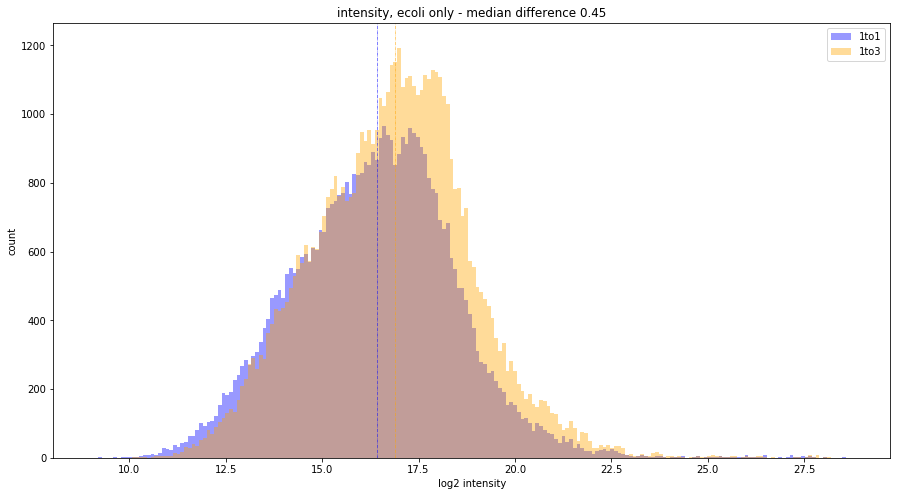

In [151]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('intensity, ecoli only - median difference {}'.format(round(abs(np.median(sequences_ecoli_1to1_df.log_intensity) - np.median(sequences_ecoli_1to3_df.log_intensity)),2)))

bins = 200
hist, bins, _ = plt.hist(sequences_ecoli_1to1_df.log_intensity, bins=bins, label='1to1', alpha=0.4, color='blue')
hist, bins, _ = plt.hist(sequences_ecoli_1to3_df.log_intensity, bins=bins, label='1to3', alpha=0.4, color='orange')

plt.axvline(np.median(sequences_ecoli_1to1_df.log_intensity), color='blue', lw=0.5, ls='-.')
plt.axvline(np.median(sequences_ecoli_1to3_df.log_intensity), color='orange', lw=0.5, ls='-.')

plt.legend(loc='best')
plt.xlabel('log2 intensity')
plt.ylabel('count')

plt.show()

In [186]:
sequences_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity_all_points',
       'intensity_saturation_adjusted', 'intensity_top_3', 'monoisotopic_mz',
       'rt_apex', 'scan_apex', 'intensity', 'classed_as', 'run_name', 'batch',
       'human', 'log_intensity', 'experiment_intensity_mean',
       'experiment_intensity_std_dev', 'experiment_rt_mean',
       'experiment_rt_std_dev', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'number_of_runs_for_sequence',
       'delta_intensity', 'estimated_delta_intensity',
       'normalised_log_intensity', 'normalised_intensity'],
      dtype='object')

In [187]:
sequences_df[['sequence','charge','log_intensity','experiment_intensity_mean','delta_intensity','estimated_delta_intensity','normalised_log_intensity']].sample(5)

,sequence,charge,log_intensity,experiment_intensity_mean,delta_intensity,estimated_delta_intensity,normalised_log_intensity
246472,CGVCEVCQQPECGK,2,14.698325,14.754562,-0.056237,-0.053162,14.751487
113652,ELLEQISAFDNVPR,2,19.128712,19.058856,0.069856,0.056929,19.071782
327009,CHVQTIQLCR,2,18.174614,17.170322,1.004291,1.003542,17.171072
172375,GPDWSGIYASDNAILAHER,3,15.582759,16.709624,-1.126864,-1.057481,16.640240
365626,LLQCYPPPEDAAVK,2,18.694749,18.465857,0.228892,0.237204,18.457545


In [190]:
sequences_df.to_pickle('/Users/darylwilding-mcbride/Downloads/sequences-df.pkl')
sequences_df.to_csv('/Users/darylwilding-mcbride/Downloads/sequences-df.csv', index=False)


In [192]:
sequences_df[sequences_df.number_of_runs_for_sequence == 3].sample(5)

,sequence,charge,file_idx,intensity_all_points,intensity_saturation_adjusted,intensity_top_3,monoisotopic_mz,rt_apex,scan_apex,intensity,...,experiment_intensity_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,number_of_runs_for_sequence,delta_intensity,estimated_delta_intensity,normalised_log_intensity,normalised_intensity
472175,IQNNDNVGKPK,2,17,187102,406563,9733,613.828083,68.961939,773.083137,9733,...,0.309280,76.414646,8.468743,781.089945,9.181808,3,-0.406417,-0.382525,19.015645,530004.326399
16171,METVSNASSSSNPSSPGR,2,0,1680,5461,252,897.901430,257.232705,411.546950,252,...,0.278212,265.206374,5.639822,438.982016,19.760010,3,-0.044448,-0.045587,12.460537,5636.316048
505275,NPPAGEEEFLLDLLTNR,2,18,2342,9974,334,964.493274,1132.128490,257.746265,334,...,0.679102,1132.169549,0.216376,261.813505,3.750387,3,-0.459888,-0.437641,13.721598,13508.667675
443999,IISLDPSDCLQPLSMQALPAQPESLCIVEMGGTEK,3,16,461,3784,152,1276.623431,1115.135889,305.000000,152,...,0.138385,1112.945324,1.732888,286.175737,18.786256,3,0.184759,0.243023,11.642673,3197.377606
223786,EPVSVGTPSEGEGLGADGQEHK,3,8,2853,141291,329,727.342260,413.407890,604.942486,329,...,0.100581,425.477064,8.601514,609.558263,5.740685,3,-0.133119,-0.121562,17.229872,153712.212869


In [193]:
sequences_df[(sequences_df.sequence == 'IQNNDNVGKPK') & (sequences_df.charge == 2)]

,sequence,charge,file_idx,intensity_all_points,intensity_saturation_adjusted,intensity_top_3,monoisotopic_mz,rt_apex,scan_apex,intensity,...,experiment_intensity_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,number_of_runs_for_sequence,delta_intensity,estimated_delta_intensity,normalised_log_intensity,normalised_intensity
147709,IQNNDNVGKPK,2,5,211653,562987,5182,613.828102,72.021745,776.240290,5182,...,0.30928,76.414646,8.468743,781.089945,9.181808,3,0.063206,0.052008,19.050734,543053.381439
309479,IQNNDNVGKPK,2,11,11072,683578,1038,613.828091,88.260252,793.946409,1038,...,0.30928,76.414646,8.468743,781.089945,9.181808,3,0.343210,0.355214,19.027532,534389.510048
472175,IQNNDNVGKPK,2,17,187102,406563,9733,613.828083,68.961939,773.083137,9733,...,0.30928,76.414646,8.468743,781.089945,9.181808,3,-0.406417,-0.382525,19.015645,530004.326399


#### check the separation between the 1:1 and 1:3 groups

In [100]:
sequences_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity_all_points',
       'intensity_saturation_adjusted', 'intensity_top_3', 'monoisotopic_mz',
       'rt_apex', 'scan_apex', 'intensity', 'classed_as', 'run_name', 'batch',
       'human', 'log_intensity', 'experiment_intensity_mean',
       'experiment_intensity_std_dev', 'experiment_rt_mean',
       'experiment_rt_std_dev', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'number_of_runs_for_sequence',
       'delta_intensity', 'estimated_delta_intensity',
       'normalised_log_intensity', 'normalised_intensity'],
      dtype='object')

In [110]:
# for each sequence and charge, if it was found in more than 5 of the 1to1 and 5 of the 1to3 runs, 
# find the mean intensity in each batch, then find the intensity ratio between batches
sequence_occurences_in_batch = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    sequence_in_1to1_df = group_df[group_df.batch == '1to1']
    sequence_in_1to3_df = group_df[group_df.batch == '1to3']
    if (len(sequence_in_1to1_df) >= 5) and (len(sequence_in_1to3_df) >= 5):
        # before norm
        average_intensity_in_1to1_before_normalisation = np.mean(sequence_in_1to1_df.intensity_saturation_adjusted)
        average_intensity_in_1to3_before_normalisation = np.mean(sequence_in_1to3_df.intensity_saturation_adjusted)
        # after norm
        average_intensity_in_1to1_after_normalisation = np.mean(sequence_in_1to1_df.normalised_intensity)
        average_intensity_in_1to3_after_normalisation = np.mean(sequence_in_1to3_df.normalised_intensity)
        human = group_df.iloc[0].human
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_batch.append((sequence, charge, average_intensity_in_1to1_before_normalisation, average_intensity_in_1to3_before_normalisation, average_intensity_in_1to1_after_normalisation, average_intensity_in_1to3_after_normalisation, human))
        
sequence_occurences_in_batch_df = pd.DataFrame(sequence_occurences_in_batch, columns=['sequence','charge','intensity_1to1_before','intensity_1to3_before','intensity_1to1_after','intensity_1to3_after','human'])

In [111]:
sequence_occurences_in_batch_df['intensity_ratio_before'] = sequence_occurences_in_batch_df.intensity_1to3_before / sequence_occurences_in_batch_df.intensity_1to1_before
sequence_occurences_in_batch_df['intensity_ratio_after'] = sequence_occurences_in_batch_df.intensity_1to3_after / sequence_occurences_in_batch_df.intensity_1to1_after


In [112]:
human_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == True]
ecoli_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == False]

In [113]:
human_df.head(10)

,sequence,charge,intensity_1to1_before,intensity_1to3_before,intensity_1to1_after,intensity_1to3_after,human,intensity_ratio_before,intensity_ratio_after
0,AAAAAAAAAAAAAAAASAGGK,2,237860.100000,264867.400000,246926.043900,249549.336546,True,1.113543,1.010624
1,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,179462.400000,315066.500000,232440.220610,232830.848363,True,1.755613,1.001681
2,AAAAAAAAVPSAGPAGPAPTSAAGR,2,16212.300000,11492.600000,13535.473398,13494.487824,True,0.708882,0.996972
3,AAAAALSQQQSLQER,2,17479.600000,19955.400000,18104.038977,17793.009140,True,1.141639,0.982820
4,AAAAATVVPPMVGGPPFVGPVGFGPGDR,3,17081.000000,26771.600000,20217.271988,19664.715181,True,1.567332,0.972669
5,AAAAAWEEPSSGNGTAR,2,157649.300000,122826.100000,139299.689722,138040.710520,True,0.779110,0.990962
6,AAAAFVLANENNIALFK,2,16929.100000,25010.500000,19882.121367,20047.558867,True,1.477367,1.008321
8,AAADGDRDCVLQK,2,44644.555556,53694.333333,47090.893726,46846.799939,True,1.202707,0.994817
9,AAAEDVNVTFEDQQK,2,289256.100000,169885.200000,222182.868967,220562.831954,True,0.587318,0.992709
10,AAAEELQEAAGAGDGATENGVQPPK,2,14968.700000,13111.700000,13813.605917,13836.841101,True,0.875941,1.001682


In [114]:
ecoli_df.head(10)

,sequence,charge,intensity_1to1_before,intensity_1to3_before,intensity_1to1_after,intensity_1to3_after,human,intensity_ratio_before,intensity_ratio_after
7,AAAAPVTGPLADDPIQETITFDDFAK,3,29770.375000,57135.400000,41691.854968,41309.393948,False,1.919203,0.990826
13,AAAFEGELIPASQIDR,2,359839.900000,365032.500000,314603.779633,323261.557864,False,1.014430,1.027520
26,AAAQLQQGLADTSDENLK,2,116962.571429,312143.900000,207940.911653,209715.641190,False,2.668750,1.008535
29,AAATGEALSLVCVDEHK,2,13066.200000,23175.222222,17969.830535,18368.735823,False,1.773677,1.022199
31,AAATQEMTLVDTPNAK,2,333275.500000,363884.800000,348475.988363,349494.292345,False,1.091844,1.002922
32,AAATQHNLEVLASR,2,19170.100000,63730.500000,33754.693636,34443.940883,False,3.324474,1.020419
37,AADAAFAEWGQTTPK,2,81540.900000,95545.300000,85415.557591,85145.602899,False,1.171747,0.996840
40,AADAHGIPFTLSTVSVCPIEEVAPAIK,3,7853.111111,45827.800000,18176.909702,20250.026101,False,5.835624,1.114052
47,AADIIGIGINGVDAVSELSK,2,104382.500000,331376.900000,184392.303644,205243.546162,False,3.174640,1.113081
48,AADIVLQAAIAAGAPK,2,237223.100000,674403.100000,397077.320295,407195.135982,False,2.842907,1.025481


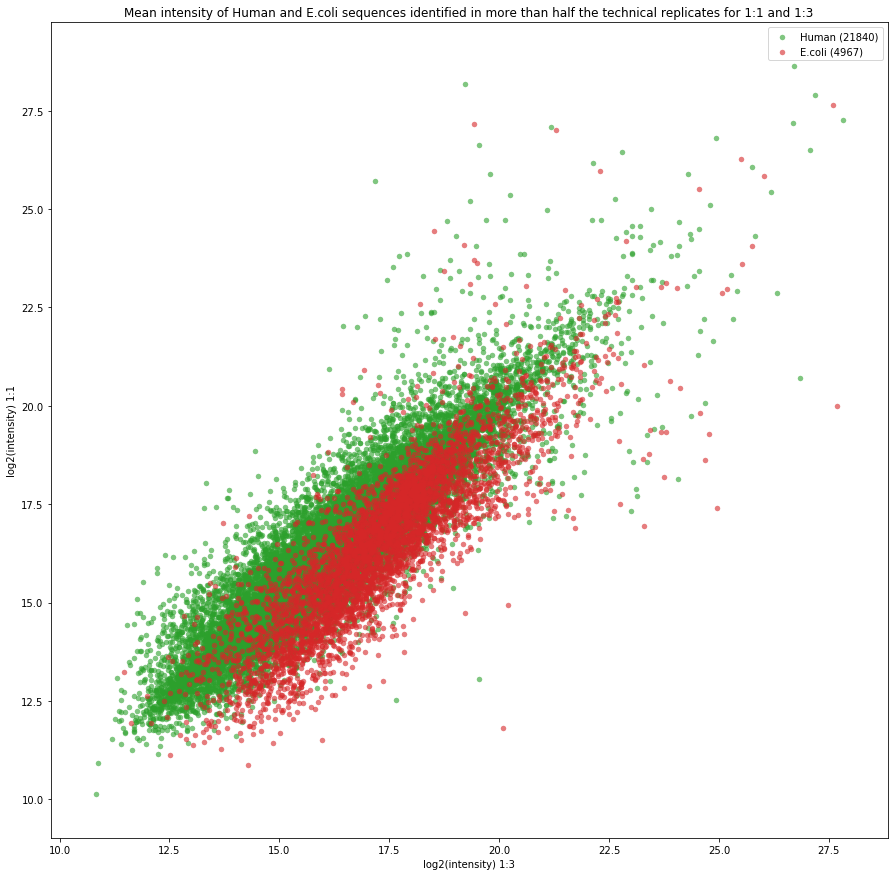

In [104]:
# For each sequence-charge identified in more than 5 runs in 1to1 and more than 5 runs in 1to3, take the average intensity in 
# each batch and plot their intensity. We should expect to see a shift in the E.coli sequences because they are 3 
# times more concentrated in the 1:3 batch.
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = 'Mean intensity of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

ax.scatter(np.log2(human_df.intensity_1to3), np.log2(human_df.intensity_1to1), marker='o', color='tab:green', lw=0, s=30, alpha=0.6, label="Human ({})".format(len(human_df)))
ax.scatter(np.log2(ecoli_df.intensity_1to3), np.log2(ecoli_df.intensity_1to1), marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli ({})".format(len(ecoli_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) 1:3')
plt.ylabel('log2(intensity) 1:1')

# plt.xlim((4,17))
# plt.ylim((4,17))

plt.show()

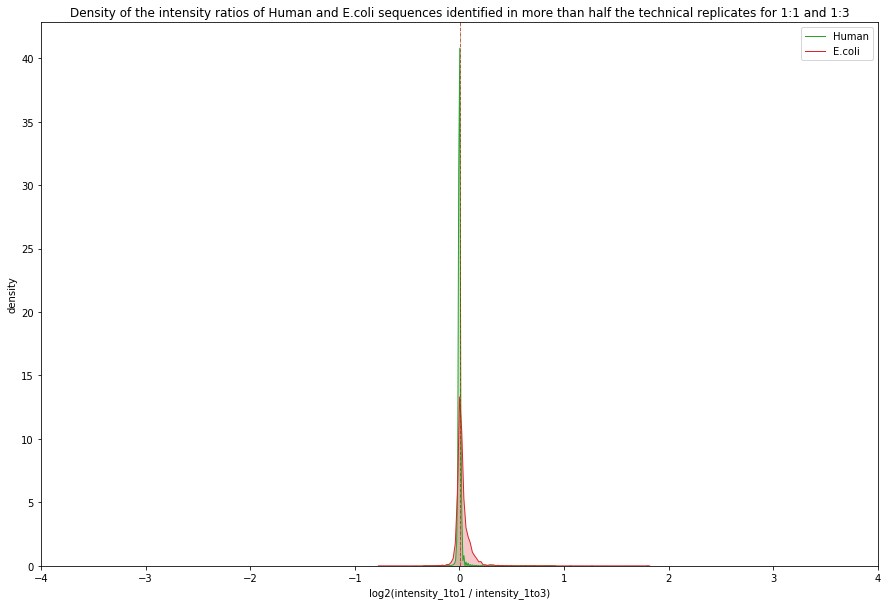

In [92]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'Density of the intensity ratios of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(np.log2(human_df['intensity_ratio']), hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(np.log2(ecoli_df['intensity_ratio']), hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'E.coli')

x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
plt.axvline(x[np.argmax(y)], color='green', lw=0.5, ls='-.')

x = ax.lines[1].get_xdata()
y = ax.lines[1].get_ydata()
plt.axvline(x[np.argmax(y)], color='red', lw=0.5, ls='-.')

_ = ax.set(xlabel='log2(intensity_1to1 / intensity_1to3)', ylabel='density')

#### plot the CVs before and after normalisation

In [93]:
sequence_cv_by_batch_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge','batch','human'], as_index=False):
    sequence = group_name[0]
    charge = group_name[1]
    batch = group_name[2]
    human = group_name[3]
    intensity_cv_before_normalisation = np.std(group_df.intensity_saturation_adjusted) / np.mean(group_df.intensity_saturation_adjusted)
    intensity_cv_after_normalisation = np.std(group_df.normalised_intensity) / np.mean(group_df.normalised_intensity)
    sequence_cv_by_batch_l.append((sequence, charge, batch, human, intensity_cv_before_normalisation, intensity_cv_after_normalisation))
sequence_cv_groups_df = pd.DataFrame(sequence_cv_by_batch_l, columns=['sequence','charge','batch','human','intensity_cv_before_normalisation', 'intensity_cv_after_normalisation'])

In [94]:
sequence_cv_groups_df.sample(5)

,sequence,charge,batch,human,intensity_cv_before_normalisation,intensity_cv_after_normalisation
22382,HGIPTAQWK,2,1to3,True,0.306421,0.010263
56425,VTLSFPSTLQTGTGTLK,2,1to3,True,0.203706,0.029674
36523,MVETLSNLLR,2,1to3,True,0.115270,0.053998
33253,LQNNNVYTIAK,2,1to3,True,0.220055,0.012448
8454,DNQHQGSYSEGAQMNGIQPEEIGR,3,1to1,True,0.160681,0.006142


In [95]:
human_1to1_df = sequence_cv_groups_df[(sequence_cv_groups_df.human == True) & (sequence_cv_groups_df.batch == '1to1')]
human_1to3_df = sequence_cv_groups_df[(sequence_cv_groups_df.human == True) & (sequence_cv_groups_df.batch == '1to3')]
ecoli_1to1_df = sequence_cv_groups_df[(sequence_cv_groups_df.human == False) & (sequence_cv_groups_df.batch == '1to1')]
ecoli_1to3_df = sequence_cv_groups_df[(sequence_cv_groups_df.human == False) & (sequence_cv_groups_df.batch == '1to3')]

##### human only, 1:1

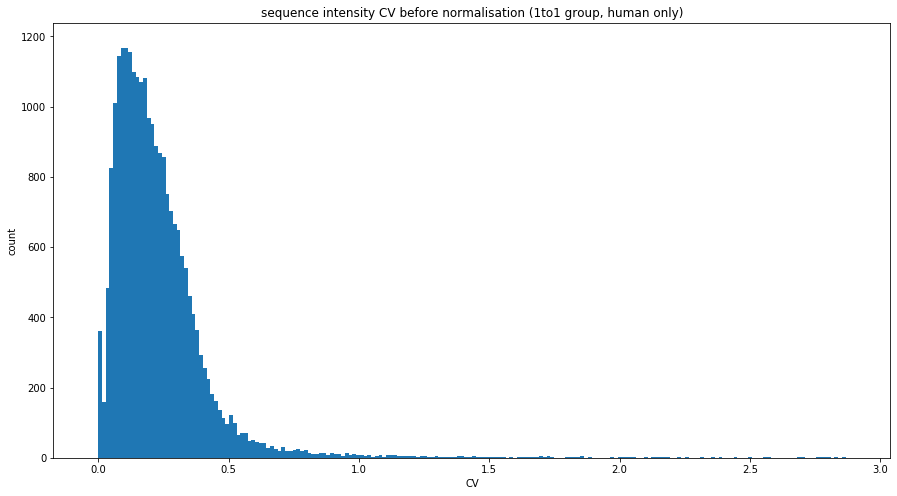

In [96]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('sequence intensity CV before normalisation (1to1 group, human only)')

bins = 200
hist, bins, _ = plt.hist(human_1to1_df.intensity_cv_before_normalisation, bins=bins)
plt.xlabel('CV')
plt.ylabel('count')

plt.show()

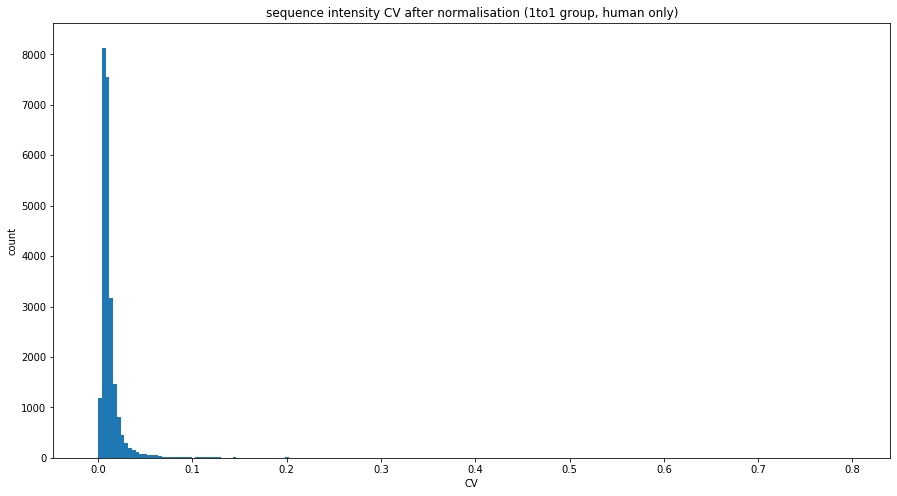

In [97]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('sequence intensity CV after normalisation (1to1 group, human only)')

bins = 200
hist, bins, _ = plt.hist(human_1to1_df.intensity_cv_after_normalisation, bins=bins)
plt.xlabel('CV')
plt.ylabel('count')

plt.show()

##### E.coli only, 1:1

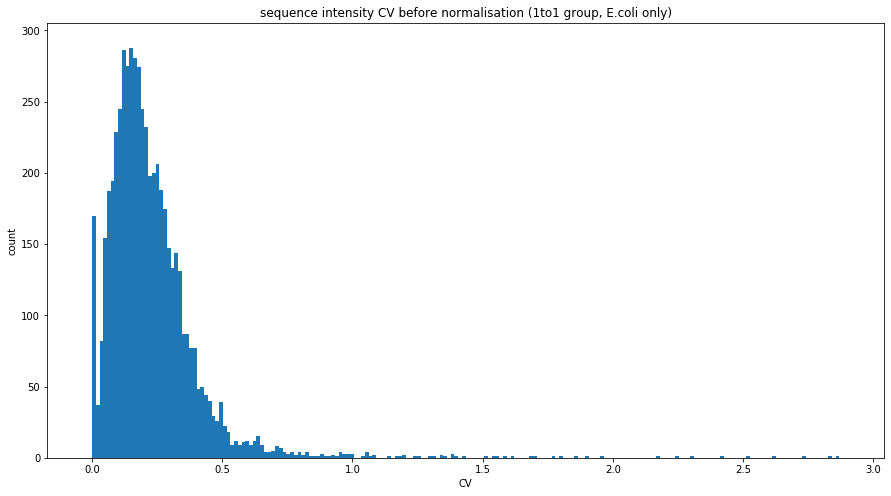

In [98]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('sequence intensity CV before normalisation (1to1 group, E.coli only)')

bins = 200
hist, bins, _ = plt.hist(ecoli_1to1_df.intensity_cv_before_normalisation, bins=bins)
plt.xlabel('CV')
plt.ylabel('count')

plt.show()

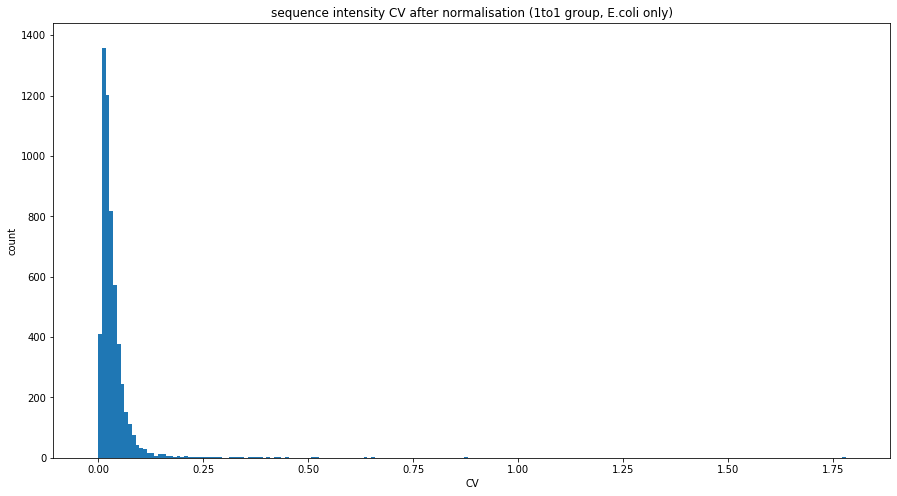

In [99]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('sequence intensity CV after normalisation (1to1 group, E.coli only)')

bins = 200
hist, bins, _ = plt.hist(ecoli_1to1_df.intensity_cv_after_normalisation, bins=bins)
plt.xlabel('CV')
plt.ylabel('count')

plt.show()

#### plot the variation of delta intensity with RT

In [ ]:
file_idx = 2
run_name = run_name_for_file_idx(file_idx)
run_name

In [ ]:
df = sequences_df.copy()
df = df[df.file_idx == file_idx]

In [ ]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('sequence intensity delta from experiment mean before normalisation for run {}'.format(run_name))

ax.scatter(df.rt_apex, df.delta_intensity, marker='o', lw=0, s=4, alpha=1.0)

plt.ylabel('sequence log2 intensity delta')
plt.xlabel('retention time')
# plt.xlim((300,400))
plt.ylim((-0.3,+0.3))

plt.show()

In [ ]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('sequence intensity delta from experiment mean after normalisation for run {}'.format(run_name))

ax.scatter(df.rt_apex, df.estimated_delta_intensity, marker='o', lw=0, s=4, alpha=1.0)

plt.ylabel('sequence log2 intensity delta')
plt.xlabel('retention time')
# plt.xlim((300,400))
plt.ylim((-0.3,+0.3))

plt.show()

In [ ]:
sequences_df